# 技术分析策略和交易系统_SMA+CCI交易系统

## 双技术指标：SMA+CCI交易系统

以SMA作为开平仓信号，同时增加CCI作为过滤器；  
当股价上穿SMA，同时CCI要小于-100，说明是在超卖的情况下，上穿SMA，做多；交易信号更可信；  
当股价下穿SMA，同时CCI要大于+100，说明是在超买的情况下，下穿SMA，做空；交易信号更可信；

In [1]:
import numpy as np
import pandas as pd
import talib as ta
import tushare as ts
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# 确保‘-’号显示正常
mpl.rcParams['axes.unicode_minus']=False
# 确保中文显示正常
mpl.rcParams['font.sans-serif'] = ['SimHei']  

### 1. 数据准备

In [2]:
# 获取数据
stock_index = ts.get_k_data('hs300', '2016-01-01', '2017-06-30')
stock_index.set_index('date', inplace=True)
stock_index.sort_index(inplace = True)
stock_index.head()

,open,close,high,low,volume,code
date,,,,,,
2016-01-04,3725.86,3470.41,3726.25,3469.01,115370674.0,hs300
2016-01-05,3382.18,3478.78,3518.22,3377.28,162116984.0,hs300
2016-01-06,3482.41,3539.81,3543.74,3468.47,145966144.0,hs300
2016-01-07,3481.15,3294.38,3481.15,3284.74,44102641.0,hs300
2016-01-08,3371.87,3361.56,3418.85,3237.93,185959451.0,hs300


In [3]:
# 计算指标sma，cci
stock_index['sma'] = ta.SMA(np.asarray(stock_index['close']), 5)
stock_index['cci'] = ta.CCI(np.asarray(stock_index['high']), np.asarray(stock_index['low']), np.asarray(stock_index['close']), timeperiod=20)

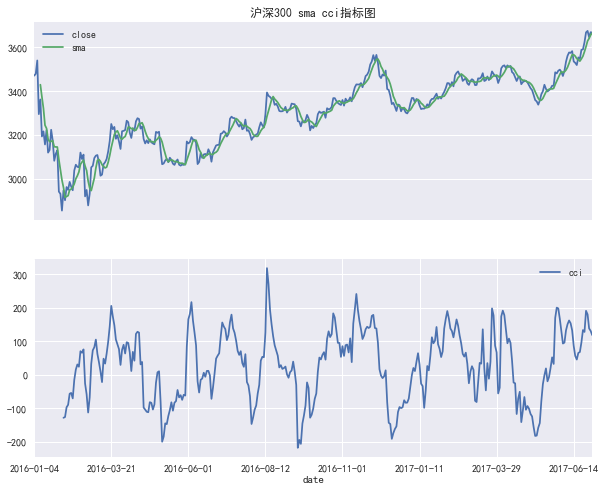

In [4]:
plt.subplot(2,1,1)
plt.title('沪深300 sma cci指标图')
plt.gca().axes.get_xaxis().set_visible(False)
stock_index['close'].plot(figsize = (10,8))
stock_index['sma'].plot(figsize=(10,8))
plt.legend()
plt.subplot(2,1,2)
stock_index['cci'].plot(figsize = (10,8))
plt.legend()
plt.show()

### 2. 交易信号、持仓信号和策略逻辑

#### 2.1 交易信号

In [5]:
# 产生开仓信号时应使用昨日及前日数据，以避免未来数据
stock_index['yes_close'] = stock_index['close'].shift(1)
stock_index['yes_sma'] = stock_index['sma'].shift(1)
stock_index['yes_cci'] = stock_index['cci'].shift(1)   #CCI是作为策略的一个过滤器；
stock_index['daybeforeyes_close'] = stock_index['close'].shift(2)
stock_index['daybeforeyes_sma'] = stock_index['sma'].shift(2)

In [ ]:
stock_index.head()

In [6]:
# 产生交易信号
# sma开多信号：昨天股价上穿SMA；
stock_index['sma_signal'] = np.where(np.logical_and(stock_index['daybeforeyes_close']<stock_index['daybeforeyes_sma'],
                                                              stock_index['yes_close']>stock_index['yes_sma']), 1, 0)
# sma开空信号：昨天股价下穿SMA
stock_index['sma_signal'] = np.where(np.logical_and(stock_index['daybeforeyes_close']>stock_index['daybeforeyes_sma'],
                                                               stock_index['yes_close']<stock_index['yes_sma']),-1,stock_index['sma_signal'])
# 产生cci做多过滤信号
stock_index['cci_filter'] = np.where(stock_index['yes_cci'] < -100, 1, 0)
# 产生cci做空过滤信号
stock_index['cci_filter']  = np.where(stock_index['yes_cci'] > 100,-1, stock_index['cci_filter'])
# 过滤后的开多信号
stock_index['filtered_signal'] = np.where(stock_index['sma_signal']+stock_index['cci_filter']==2, 1, 0)
# 过滤后的开空信号
stock_index['filtered_signal'] = np.where(stock_index['sma_signal']+stock_index['cci_filter']==-2, -1,stock_index['filtered_signal'])
# 生成交易信号


In [7]:
stock_index.tail()

,open,close,high,low,volume,code,sma,cci,yes_close,yes_sma,yes_cci,daybeforeyes_close,daybeforeyes_sma,sma_signal,cci_filter,filtered_signal
date,,,,,,,,,,,,,,,,
2017-06-26,3627.02,3668.09,3671.94,3627.02,134637995.0,hs300,3603.152,190.662244,3622.88,3580.268,127.766972,3590.34,3559.444,0,-1,0
2017-06-27,3665.58,3674.72,3676.53,3648.76,97558702.0,hs300,3628.798,180.056339,3668.09,3603.152,190.662244,3622.88,3580.268,0,-1,0
2017-06-28,3664.16,3646.17,3672.19,3644.03,97920858.0,hs300,3640.440,138.038475,3674.72,3628.798,180.056339,3668.09,3603.152,0,-1,0
2017-06-29,3649.25,3668.83,3669.13,3644.73,85589498.0,hs300,3656.138,130.685000,3646.17,3640.440,138.038475,3674.72,3628.798,0,-1,0
2017-06-30,3654.73,3666.80,3669.76,3646.23,81510028.0,hs300,3664.922,118.314672,3668.83,3656.138,130.685000,3646.17,3640.440,0,-1,0


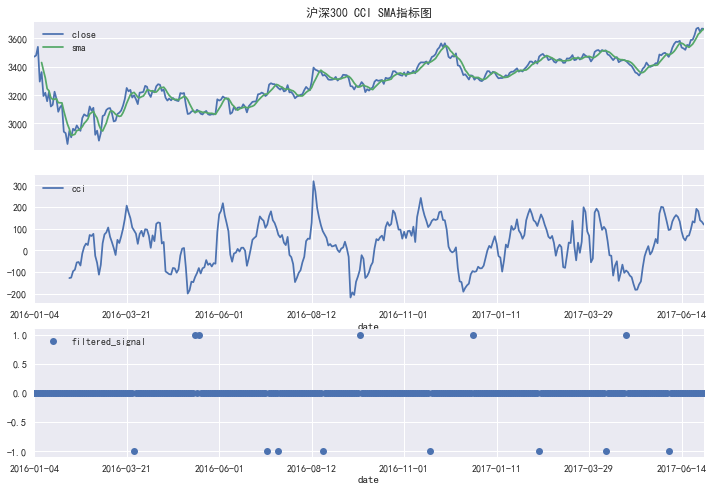

In [8]:
# 绘制cci，sma指标图
plt.subplot(3,1,1)
plt.title('沪深300 CCI SMA指标图')
plt.gca().axes.get_xaxis().set_visible(False)
stock_index['close'].plot(figsize=(12,8))
stock_index['sma'].plot()
plt.legend(loc='upper left')
plt.subplot(3,1,2)
stock_index['cci'].plot(figsize=(12, 8))
plt.legend(loc='upper left')
plt.subplot(3,1,3)
stock_index['filtered_signal'].plot(figsize=(12, 8), marker='o', linestyle='')
plt.legend(loc='upper left')
plt.show()

#### 2.2 持仓信号

In [9]:
# 记录持仓情况，默认为0
position = 0
# 对每一交易日进行循环
for i, item in stock_index.iterrows():
    # 判断交易信号
    if item['filtered_signal'] == 1:
        # 交易信号为1，则记录仓位为1
        position = 1
    elif item['filtered_signal'] == -1:
        # 交易信号为-1， 则记录仓位为-1
        position = -1
    else:
        pass
    # 记录每日持仓情况
    stock_index.loc[i, 'position'] = position

In [ ]:
stock_index.head()

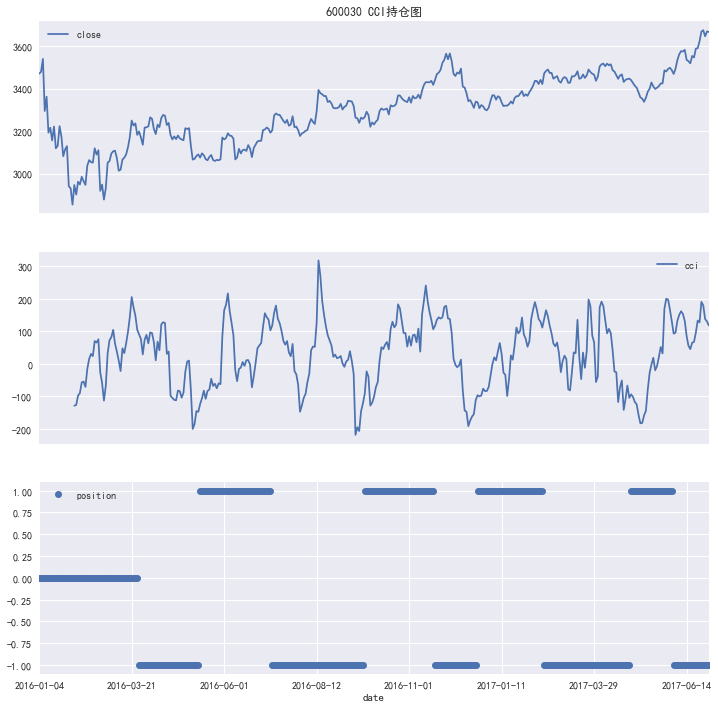

In [10]:
plt.subplot(3, 1, 1)
plt.title('600030 CCI持仓图')
plt.gca().axes.get_xaxis().set_visible(False)
stock_index['close'].plot(figsize = (12,12))
plt.legend()
plt.subplot(3, 1, 2)
stock_index['cci'].plot(figsize = (12,12))
plt.legend()
plt.gca().axes.get_xaxis().set_visible(False)
plt.subplot(3, 1, 3)
stock_index['position'].plot(marker='o', figsize=(12,12),linestyle='')
plt.legend()
plt.show()

### 3.策略收益和数据可视化

In [11]:
# 计算策略收益
# 计算股票每日收益率
stock_index['pct_change'] = stock_index['close'].pct_change()
# 计算策略每日收益率
stock_index['strategy_return'] = stock_index['pct_change'] * stock_index['position']
# 计算股票累积收益率
stock_index['return'] = (stock_index['pct_change']+1).cumprod()
# 计算策略累积收益率
stock_index['strategy_cum_return'] = (1 + stock_index['strategy_return']).cumprod()

In [12]:
stock_index.head()

,open,close,high,low,volume,code,sma,cci,yes_close,yes_sma,...,daybeforeyes_close,daybeforeyes_sma,sma_signal,cci_filter,filtered_signal,position,pct_change,strategy_return,return,strategy_cum_return
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,3725.86,3470.41,3726.25,3469.01,115370674.0,hs300,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0.0,NaN,NaN,NaN,NaN
2016-01-05,3382.18,3478.78,3518.22,3377.28,162116984.0,hs300,NaN,NaN,3470.41,NaN,...,NaN,NaN,0,0,0,0.0,0.002412,0.0,1.002412,1.0
2016-01-06,3482.41,3539.81,3543.74,3468.47,145966144.0,hs300,NaN,NaN,3478.78,NaN,...,3470.41,NaN,0,0,0,0.0,0.017544,0.0,1.019998,1.0
2016-01-07,3481.15,3294.38,3481.15,3284.74,44102641.0,hs300,NaN,NaN,3539.81,NaN,...,3478.78,NaN,0,0,0,0.0,-0.069334,-0.0,0.949277,1.0
2016-01-08,3371.87,3361.56,3418.85,3237.93,185959451.0,hs300,3428.988,NaN,3294.38,NaN,...,3539.81,NaN,0,0,0,0.0,0.020392,0.0,0.968635,1.0


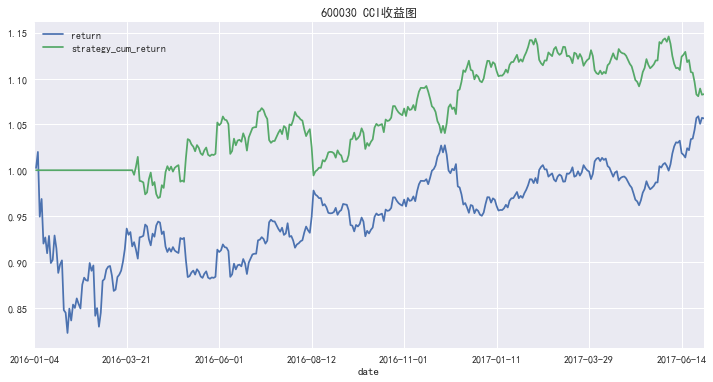

In [13]:
# 将股票累积收益率和策略累积收益率绘图
stock_index[['return', 'strategy_cum_return']].plot(figsize = (12,6))

plt.title('600030 CCI收益图')
plt.legend()
plt.show()

声明：本资料仅供内部学习交流使用，切勿外传。